In [1]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.fftpack import fft
from scipy.signal import find_peaks, hilbert
from tqdm import tqdm
import matplotlib.pyplot as plt
import pywt
# Define the FitzHugh-Nagumo model equations
def fitzhugh_nagumo_coupled(t, xy,alpha , w2, a, b, c, k1, k2):
    x, y , x1, y1= xy
    dxdt = alpha*(y + x - (x**3)/3 + (k1 + c*x1))
    dydt = -(1/alpha) * (w2*x - a + b*y)
    dx1dt = alpha*(y1 + x1 - (x1**3)/3 + (k2 + c*x))
    dy1dt = -(1/alpha) * (w2*x1 - a + b*y1)
    return [dxdt, dydt, dx1dt, dy1dt]

# Define events
# def R_idx(s1,s2):
#     h1 = hilbert(s1)
#     h2 = hilbert(s2)
#     p1 = np.angle(h1)
#     p2 = np.angle(h2)
#     p_diff = p1-p2
#     R = np.abs(np.mean(np.exp(1j*p_diff)))
#     return R
    
def R_idx(s1, s2):
    #use the Morlet wavele
    wavelet = "cmor1.5-1.0"
    scales = np.arange(1,40) #range of scales
    coi = [2,39] # cone of influence

    #compute the cwt
    cwt_s1, freq_s1 = pywt.cwt(s1, scales, wavelet, sampling_period=40)
    cwt_s2, freq_s2 = pywt.cwt(s2, scales, wavelet, sampling_period=40)

    #find the phases
    p1 = np.angle(cwt_s1)
    p2 = np.angle(cwt_s2)
    p_diff= p1-p2

    #find the dominating freq of frequency s1
    p_diff = p_diff[np.argmax(np.sum(np.abs(cwt_s1),axis=1)),:]

    R = np.abs(np.mean(np.exp(1j*p_diff)))
    return R

# Define the initial conditions and parameter values
alpha = 3
a = 0.7
b = 0.8
w2 = 1
x0 = 0
y0 = 0
x10 = 0
y10 = 0
xy0=[x0, x10, y0, y10]
c_vals = np.linspace(-0.3,0,num=30)
k1_vals = np.array([-0.3 for i in range(30)])
k2_vals = np.linspace(-0.65,-0.9, num=30)
t_span = [0, 200]
t_eval = np.linspace(0,200,10000)

In [2]:

Rmap = np.zeros((c_vals.shape[0], k1_vals.shape[0]))
for i, c in tqdm(enumerate(c_vals)):
    for j, k2 in enumerate(k2_vals):
        k1 = k1_vals[len(k1_vals)-1-j] 
        sol = solve_ivp(fitzhugh_nagumo_coupled, t_span, xy0, args=(alpha,w2,a,b,c,k1,k2),t_eval=t_eval,dense_output=True,rtol=1e-8)

        s1 = sol.y[0]
        s2 = sol.y[2]
        
        #Apply hamming filter
        window = np.hamming(s1.shape[0])
        s1 = s1 * window 
        s2 = s2 * window
        
        #Calculate R index
        R = R_idx(s1,s2)
        
        #Save to response map
        Rmap[i, j] = R

30it [05:14, 10.49s/it]


In [3]:
Rmap

array([[0.7937986 , 0.78768135, 0.78488704, 0.77462469, 0.77119832,
        0.75983628, 0.7527187 , 0.7418076 , 0.72790481, 0.7201698 ,
        0.69049887, 0.69125275, 0.66802544, 0.65660092, 0.64236809,
        0.62726654, 0.61045889, 0.59429699, 0.57414259, 0.55762036,
        0.53559861, 0.51534726, 0.49335367, 0.46713563, 0.43865145,
        0.42095421, 0.38429745, 0.36344344, 0.33761425, 0.30366585],
       [0.8141213 , 0.80841733, 0.81540958, 0.8031776 , 0.79035153,
        0.78313217, 0.77721609, 0.76701714, 0.76162701, 0.74817342,
        0.74276433, 0.72564465, 0.72019854, 0.69610338, 0.68269914,
        0.6667346 , 0.65230874, 0.639609  , 0.62118815, 0.60623847,
        0.58716069, 0.56786351, 0.54934038, 0.52660613, 0.50684569,
        0.48329904, 0.45631968, 0.42775491, 0.40795157, 0.37115947],
       [0.80524344, 0.80789848, 0.8162226 , 0.81433232, 0.81622805,
        0.80888378, 0.8150465 , 0.7982914 , 0.78313603, 0.77843735,
        0.76699999, 0.76037419, 0.74840332, 0.

30it [00:00, 172368.66it/s]


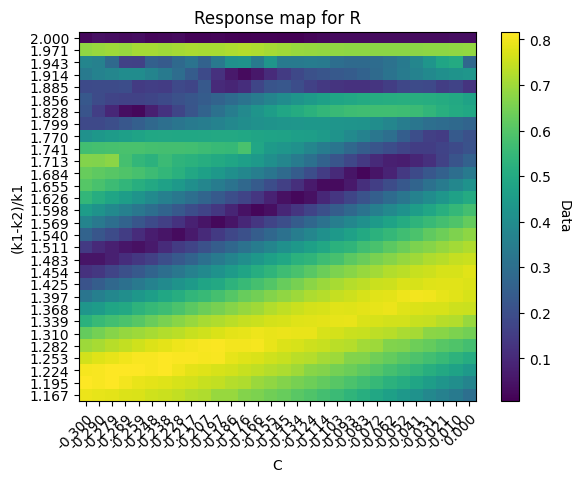

In [4]:
K = []
C = []
for i, c in tqdm(enumerate(c_vals)):
    C.append(c)
for j, k2 in enumerate(k2_vals):
    K.append((k2+0.3)/(-0.3))      

# plt.imshow(Rmap, cmap='viridis', origin='lower', aspect='auto',)
fig, ax = plt.subplots()
im = ax.imshow(Rmap, cmap='viridis', origin='lower', aspect='auto',)

# Set tick labels
ax.set_xticks(np.arange(len(C)))
ax.set_yticks(np.arange(len(K)))
ax.set_xticklabels([f"{c:.3f}" for c in C])
ax.set_yticklabels([f"{k:.3f}" for k in K])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Data', rotation=-90, va="bottom")

# Add axis labels
ax.set_xlabel('C')
ax.set_ylabel('(k1-k2)/k1')
ax.set_title("Response map for R")
# Show plot
plt.show()

In [5]:
zs = [-0.3,-0.4,-0.5,-0.6,-0.7]
k1 = -0.3
k2 = -0.7346
c = -0.0207
# k1 = -0.3
# k2 = -0.68
# c = -0.3
sol = solve_ivp(fitzhugh_nagumo_coupled, t_span, xy0, args=(alpha,w2,a,b,c,k1,k2), t_eval=t_eval, dense_output=True,rtol=1e-8)
t = sol.t
s1 = sol.y[0]
s2 = sol.y[2]

In [6]:
t

array([0.00000000e+00, 2.00020002e-02, 4.00040004e-02, ...,
       1.99959996e+02, 1.99979998e+02, 2.00000000e+02])

In [7]:
s1

array([ 0.        , -0.01838055, -0.03754319, ...,  1.62281728,
        1.61801692,  1.61323391])

In [8]:
s2

array([ 0.        , -0.04527168, -0.09300575, ...,  1.54818632,
        1.60376745,  1.65358031])

In [9]:
wavelet = "cmor1.5-1.0"
scales = np.arange(1,40) #range of scales
coi = [2,39] # cone of influence

#compute the cwt
cwt_s1, freq_s1 = pywt.cwt(s1, scales, wavelet, sampling_period=40)
cwt_s2, freq_s2 = pywt.cwt(s2, scales, wavelet, sampling_period=40)

#find the phases
p1 = np.angle(cwt_s1)
p2 = np.angle(cwt_s2)
p_diff= p1-p2

p_diff

array([[-2.46762581e-04, -8.01986990e-04, -1.44519122e-03, ...,
         3.30547388e+00,  4.68497749e+00, -3.60336614e-02],
       [ 3.99511897e-04,  4.03375635e-04,  3.15134590e-04, ...,
         5.00520450e-04,  6.67318264e-04,  8.22769458e-04],
       [ 3.29245988e-03,  2.17891606e-03,  8.74562926e-03, ...,
         6.80934858e-03,  4.92059509e-03,  1.21903789e-02],
       ...,
       [-5.87844705e-01, -6.20063380e-01, -6.59093675e-01, ...,
         3.54359878e-01,  3.58103897e-01,  3.45344020e-01],
       [-6.92122179e-01, -7.27339105e-01, -7.68972054e-01, ...,
         3.64869737e-01,  3.69450799e-01,  3.57080378e-01],
       [-7.80019916e-01, -8.07989609e-01, -8.41526411e-01, ...,
         3.79324029e-01,  3.84988894e-01,  3.73009469e-01]])

In [10]:
np.sum(np.abs(cwt_s1),axis=1)

array([1.48511040e+01, 2.85933144e-01, 2.02918320e+00, 9.33890420e-01,
       4.00259331e+00, 1.80476843e+00, 6.44618550e+00, 2.88791343e+00,
       9.49795803e+00, 4.47302856e+00, 5.70901489e+00, 6.48278672e+00,
       1.64785827e+01, 1.01609358e+01, 1.34406687e+01, 1.55151644e+01,
       2.05360404e+01, 2.44373871e+01, 3.00614094e+01, 3.69350128e+01,
       5.46824538e+01, 5.43624664e+01, 6.51581724e+01, 7.69247768e+01,
       9.09547755e+01, 1.06121612e+02, 1.22987498e+02, 1.41833251e+02,
       1.62771280e+02, 1.85071502e+02, 2.08616591e+02, 2.33316506e+02,
       2.60826217e+02, 2.89712325e+02, 3.20581346e+02, 3.54236691e+02,
       3.91335609e+02, 4.30363317e+02, 4.71900631e+02])

In [11]:
np.sum(np.abs(cwt_s2),axis=1)

array([2.49623847e+01, 3.03887984e-01, 3.05110330e+00, 9.94405567e-01,
       5.88757725e+00, 1.93907680e+00, 9.40846455e+00, 3.14879037e+00,
       1.38570928e+01, 5.12895626e+00, 6.81840372e+00, 7.86104091e+00,
       2.39678528e+01, 1.35343150e+01, 1.86588537e+01, 2.25160932e+01,
       3.07584294e+01, 3.79346701e+01, 4.79956951e+01, 6.03489931e+01,
       8.88866467e+01, 9.24667623e+01, 1.12816241e+02, 1.35300259e+02,
       1.62368161e+02, 1.91765151e+02, 2.24389554e+02, 2.60631958e+02,
       3.00864859e+02, 3.44349607e+02, 3.90846737e+02, 4.40161644e+02,
       4.95778641e+02, 5.53939309e+02, 6.15734931e+02, 6.80762134e+02,
       7.50574647e+02, 8.22507507e+02, 8.98732900e+02])

In [12]:
#find the dominating freq of frequency s1
p_diff = p_diff[np.argmax(np.sum(np.abs(cwt_s1),axis=1)),:]

R = np.abs(np.mean(np.exp(1j*p_diff)))
R

0.3398132988561196

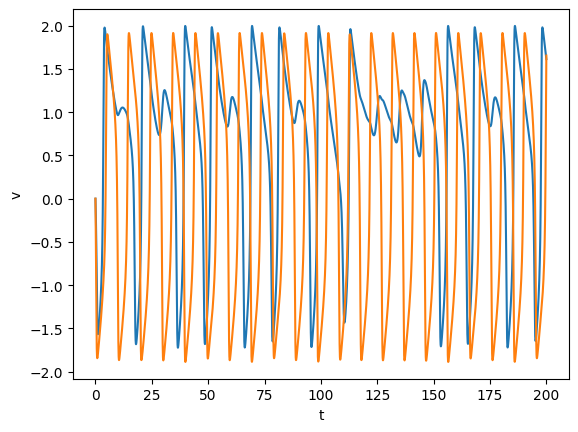

In [13]:
# plt.plot(t[0:100], (np.abs(np.fft.fft(v))**2)[0:100])
plt.plot(t, s1)
plt.plot(t, s2)
plt.xlabel('t')
plt.ylabel('v')
plt.show()